# Upper and middle class workers in Ile de France

In [1]:
from pynsee import *

import pandas as pd
import geopandas as gpd
from pathlib import Path
from contextlib import closing
# import urllib.request as request
from urllib.request import Request, urlopen
import os
import py7zr
import re
import shutil

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
meta = get_file_list()
meta[meta.id.str.contains("RP_ACTRES_IRIS")].T.dropna()

pynsee.download's metadata rely on volunteering contributors and their manual updates. get_file_list does not provide data from official Insee's metadata API
Consequently, please report any issue


,1332
id,RP_ACTRES_IRIS
name,RP_ACTRES_IRIS
label,"Données du Recensement de Population, données ..."
collection,RP
link,https://www.insee.fr/fr/statistiques/fichier/4...
type,xlsx
zip,True
big_zip,False
data_file,base-ic-activite-residents-2017.xlsx
tab,IRIS


In [4]:
dfraw = download_file("RP_ACTRES_IRIS")

Downloading: 100%|██████████| 58.0M/58.0M [00:02<00:00, 20.8MiB/s]
Extracting: 100%|██████████| 58.0M/58.0M [00:00<00:00, 637MB/s]


Data saved:
/home/onyxia/.cache/pynsee/pynsee/f68f175baadf284aadfd854e462a0cce.parquet


In [5]:
# Metadata from insee.fr : https://www.insee.fr/fr/statistiques/4799323#dictionnaire
# P17_ACT1564 : nombre de personnes actives de 15 à 64 ans
# C17_ACT1564 : nombre de personnes actives de 15 à 64 ans
# C17_ACT1564_CS1 : nombre d'agriculteurs exploitants actifs de 15 à 64 ans
# C17_ACT1564_CS2 : nombre d'artisans, commerçants, chefs d'entreprise actifs de 15 à 64 ans
# C17_ACT1564_CS3 : nombre de cadres et professions intellectuelles supérieures actifs de 15 à 64 ans

In [6]:
df = dfraw[["IRIS", "COM", "REG", "DEP", "LIBCOM", "C17_ACT1564", "C17_ACT1564_CS2", "C17_ACT1564_CS3"]]
df = df[(df["REG"] == "11") ] #& ~(df["DEP"] == "77")
df["C17_ACT1564_CS2"] = pd.to_numeric(df["C17_ACT1564_CS2"])
df["C17_ACT1564_CS3"] = pd.to_numeric(df["C17_ACT1564_CS3"])
df["C17_ACT1564"] = pd.to_numeric(df["C17_ACT1564"])
df["pct"] = 100 * (df["C17_ACT1564_CS2"] + df["C17_ACT1564_CS3"]) / df["C17_ACT1564"]

df = df.reset_index(drop=True)
df

,IRIS,COM,REG,DEP,LIBCOM,C17_ACT1564,C17_ACT1564_CS2,C17_ACT1564_CS3,pct
0,751010101,75101,11,75,Paris 1er Arrondissement,520.643927,29.702144,190.009987,42.200076
1,751010102,75101,11,75,Paris 1er Arrondissement,71.145629,9.899243,36.903044,65.783784
2,751010103,75101,11,75,Paris 1er Arrondissement,107.952527,18.057574,55.539455,68.175365
3,751010104,75101,11,75,Paris 1er Arrondissement,0.000000,0.000000,0.000000,NaN
4,751010105,75101,11,75,Paris 1er Arrondissement,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...
5257,956800112,95680,11,95,Villiers-le-Bel,831.396737,54.511641,35.417896,10.816681
5258,956800113,95680,11,95,Villiers-le-Bel,885.164069,26.592849,32.183605,6.640176
5259,956800114,95680,11,95,Villiers-le-Bel,664.336730,24.113011,11.521560,5.363932
5260,956820000,95682,11,95,Villiers-le-Sec,117.460317,4.894180,24.470899,25.000000


In [7]:
import os
import shutil
from pathlib import Path
from urllib.request import Request, urlopen
from contextlib import closing

ign_iris_2022 = "https://data.geopf.fr/telechargement/download/CONTOURS-IRIS/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01.7z"

def get_iris_data(url=ign_iris_2022, update=False):
    list_string_split = url.split("/")
    filename = list_string_split[-1]
    list_string_split_filename = filename.split(".")
    filename_clean = list_string_split_filename[0]
    
    home = Path.home()
    dataDir = os.path.join(home, filename_clean)
    if not os.path.exists(dataDir):
        os.mkdir(dataDir)

    file_iris = os.path.join(dataDir, "file_" + filename_clean)

    req = Request(
        url=url, 
        headers={'User-Agent': 'Mozilla/5.0'},
    )
        
    if not os.path.exists(file_iris) or update:
        with closing(urlopen(req)) as r:
            with open(file_iris, 'wb') as f:
                shutil.copyfileobj(r, f)

    with py7zr.SevenZipFile(file_iris, mode='r') as z:
            z.extractall(dataDir)

    list_file = []
    list_file_size = []

    for root, d_names, f_names in os.walk(dataDir):
        for f in f_names:
            filename = root + "/" + f
            if re.search("CONTOURS-IRIS.shp", filename):
                list_file += [filename]
                list_file_size += [os.path.getsize(filename)]
    
    list_shp_df = []
                
    for f in list_file:  
               
        shp = gpd.read_file(f)
        shp = shp.to_crs("EPSG:3857")
        list_shp_df += [shp]
        
    shpFinal = pd.concat(list_shp_df)

    return shpFinal

# Example call to the function
shapefile = get_iris_data()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [8]:
shp = shapefile.sort_values(by = ["INSEE_COM"]).reset_index(drop=True)

In [9]:
DF = df.merge(shp[["CODE_IRIS", "geometry"]], how = "left", left_on = "IRIS", right_on = "CODE_IRIS")

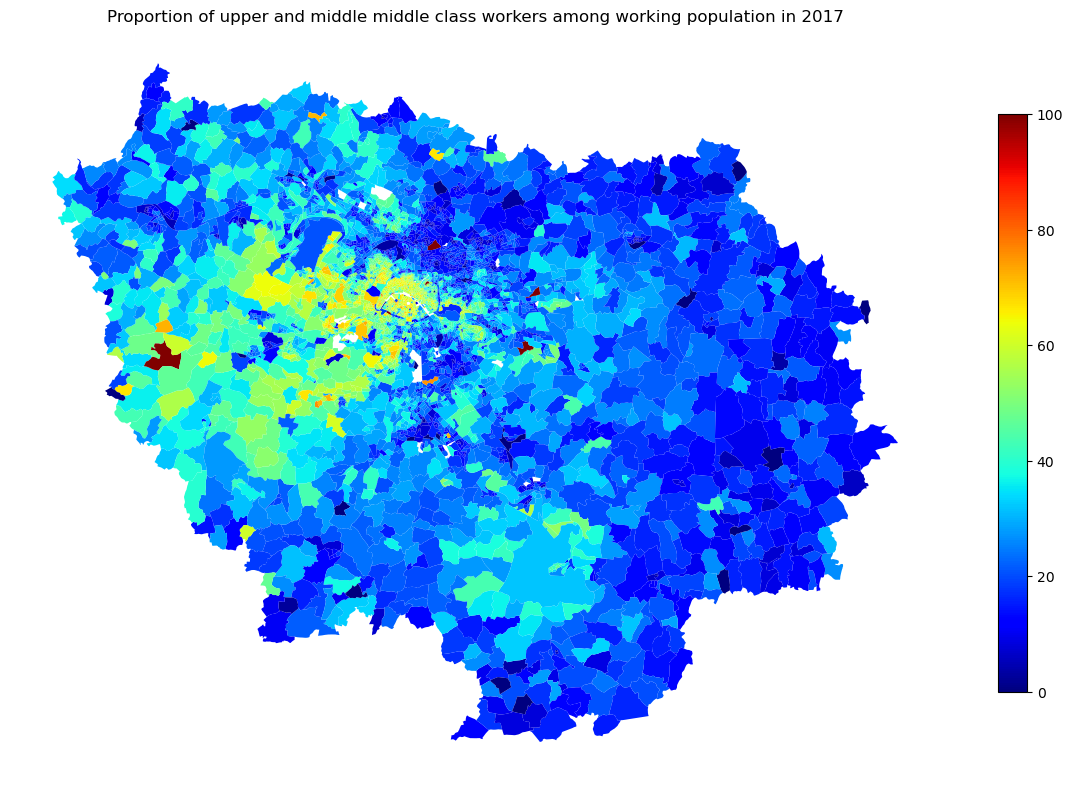

In [10]:
mapplot = gpd.GeoDataFrame(DF).set_crs("EPSG:3857")

fig, ax = plt.subplots(1,1,figsize=[15,15])
mapplot.plot(column='pct', cmap=cm.jet,
    legend=True, ax=ax, legend_kwds={'shrink': 0.5})
ax.set_axis_off()
ax.set(title='Proportion of upper and middle middle class workers among working population in 2017')
plt.show()